# LCRTest1

## Setup and Data

In [1]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#These are imported specifically for the use of the histogram.
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import gridspec
from scipy import stats

#Imported for categorization of the Sources
from fractional_variability import fvar
from fermi_catalog import select_bll, select_fsrq, select_bcu

In [2]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
#print(cadence_df)

TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

In [3]:
# This function takes the dataframe of sources of variable objects, and the name of a source.
# It will sort through every entry in the dataframe, and detect consecutive entries with a flux level higher than the average.
# It counts the duration of these flaring states, and notes them in an array 'final', which it returns upon completion.
def flare_detector(name,met,flux,eflux):
    final = [0,0,0]
    k=0
    temp =[]
    temp_err=[]
    duration = []
    average=[]
    # This section is for setting up our dataframes which will be used in the following loop.
    # We primarily are eliminating outliers and NaN values that were marked with -3333.
    #sourcematrix = dataframe.loc[dataframe['source_name'] == name].reset_index(drop=True)
    fluxmatrix = flux
    averageflux = np.mean(fluxmatrix)
    errormatrix = eflux
    boolmatrix = fluxmatrix/averageflux > 1  
    boolmatrix = boolmatrix
    for i in range(len(fluxmatrix)):
        # If the flux value for index i is greater than the average, then this condition is met.
        if boolmatrix[i] == True:
            temp.append(fluxmatrix[i])
            temp_err.append(errormatrix[i])
        # If the flux value is not above average, and there are values stored in the temp array, we gather them and send them to 'final'.
        elif len(temp) != 0:
            if i != 0:
                duration = ((len(temp)))
                average = np.nanmean(temp)
                error = ((sum(k*k for k in temp_err))**0.5)*(1/(len(temp_err)))
                temp = []
                temp_err = []
                final = np.vstack([final,[duration,average,error]])
        # Otherwise, we add a row of 0's to show that the source has no flaring states.
        else:
            final = np.vstack([final,[0,0,0]])


    return final

In [5]:
#Read new red+white fluence curves
base = 'shared_plot_arrays/'
bcu_fluencecount_rep=np.load(base+'bcu_fluencecount.npy')
bll_fluencecount_rep=np.load(base+'bll_fluencecount.npy')
fsrq_fluencecount_rep=np.load(base+'fsrq_fluencecount.npy')[:-1]
bcu_fluencecount_error_rep=np.load(base+'bcu_fluencecount_error.npy')
bll_fluencecount_error_rep=np.load(base+'bll_fluencecount_error.npy')
fsrq_fluencecount_error_rep=np.load(base+'fsrq_fluencecount_error.npy')[:-1]
bll_fluencethresholds_rep=np.load(base+'bll_fluencethresholds.npy')
bcu_fluencethresholds_rep=np.load(base+'bcu_fluencethresholds.npy')
fsrq_fluencethresholds_rep=np.load(base+'fsrq_fluencethresholds.npy')[:-1]

In [35]:
#Flare identification on simulated red noise LCs
# These three loops will run the flare_detector function for each category of blazar.
import glob
import numpy as np
from tqdm import tqdm

cadence='daily'
#cadence='weekly'
#cadence='monthly'

#index=np.linspace(0,9,10)
index=np.linspace(0,999,1000)
fsrq_list_red=glob.glob('./simulated_LC_FSRQ_'+cadence+'_contours_red/*')
fluencethreshold_fsrq_all_red=[]
fluencecount_fsrq_all_red=[]

for idx in tqdm(index):
    fsrq_flares_sim_all_red = [0,0,0]
    for fsrq_sim in fsrq_list_red:
        #fsrq_flares_sim = [0,0,0]
        fsrq_files_sim_red=glob.glob(fsrq_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_red=np.loadtxt(fsrq_files_sim_red[0])
        met_sim_red=data_sim_red[:,0]
        flux_sim_red=data_sim_red[:,1]
        eflux_sim_red=data_sim_red[:,2]
        fsrq_flares_sim_all_red = np.vstack([fsrq_flares_sim_all_red,flare_detector(name,met_sim_red,flux_sim_red,eflux_sim_red)])
        
    fsrq_filtered_sim_red = fsrq_flares_sim_all_red[fsrq_flares_sim_all_red[:,0] != 0]
    fsrq_flareduration_sim_red = fsrq_filtered_sim_red[:,0]
    fsrq_flareflux_sim_red = fsrq_filtered_sim_red[:,1]
    fsrq_flareduration_sim_red = np.asarray(fsrq_flareduration_sim_red,dtype='float64')
    fsrq_flareflux_sim_red = np.asarray(fsrq_flareflux_sim_red,dtype='float64')
    fsrq_fluence_sim_red = np.multiply(fsrq_flareflux_sim_red,fsrq_flareduration_sim_red)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    fsrq_fluencecount_sim_red = np.zeros(len(fsrq_fluence_sim_red))
    fsrq_fluencethresholds_sim_red = sorted(fsrq_fluence_sim_red)
    for i in range(0,len(fsrq_fluence_sim_red)):
        fsrq_fluencecount_sim_red[i] = len(fsrq_fluence_sim_red[fsrq_fluence_sim_red>fsrq_fluencethresholds_sim_red[i]])
    fluencethreshold_fsrq_all_red.append(fsrq_fluencethresholds_sim_red)
    fluencecount_fsrq_all_red.append(fsrq_fluencecount_sim_red)        

bll_list_red=glob.glob('./simulated_LC_BLL_'+cadence+'_contours_red/*')
fluencethreshold_bll_all_red=[]
fluencecount_bll_all_red=[]

for idx in tqdm(index):
    bll_flares_sim_all_red = [0,0,0]
    for bll_sim in bll_list_red:
        #bll_flares_sim = [0,0,0]
        bll_files_sim_red=glob.glob(bll_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_red=np.loadtxt(bll_files_sim_red[0])
        met_sim_red=data_sim_red[:,0]
        flux_sim_red=data_sim_red[:,1]
        eflux_sim_red=data_sim_red[:,2]
        bll_flares_sim_all_red = np.vstack([bll_flares_sim_all_red,flare_detector(name,met_sim_red,flux_sim_red,eflux_sim_red)])
        
    bll_filtered_sim_red = bll_flares_sim_all_red[bll_flares_sim_all_red[:,0] != 0]
    bll_flareduration_sim_red = bll_filtered_sim_red[:,0]
    bll_flareflux_sim_red = bll_filtered_sim_red[:,1]
    bll_flareduration_sim_red = np.asarray(bll_flareduration_sim_red,dtype='float64')
    bll_flareflux_sim_red = np.asarray(bll_flareflux_sim_red,dtype='float64')
    bll_fluence_sim_red = np.multiply(bll_flareflux_sim_red,bll_flareduration_sim_red)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    bll_fluencecount_sim_red = np.zeros(len(bll_fluence_sim_red))
    bll_fluencethresholds_sim_red = sorted(bll_fluence_sim_red)
    for i in range(0,len(bll_fluence_sim_red)):
        bll_fluencecount_sim_red[i]=len(bll_fluence_sim_red[bll_fluence_sim_red>bll_fluencethresholds_sim_red[i]])
    fluencethreshold_bll_all_red.append(bll_fluencethresholds_sim_red)
    fluencecount_bll_all_red.append(bll_fluencecount_sim_red)

bcu_list_red=glob.glob('./simulated_LC_BCU_'+cadence+'_contours_red/*')
fluencethreshold_bcu_all_red=[]
fluencecount_bcu_all_red=[]

for idx in tqdm(index):
    bcu_flares_sim_all_red = [0,0,0]
    for bcu_sim in bcu_list_red:
        #bcu_flares_sim = [0,0,0]
        bcu_files_sim_red = glob.glob(bcu_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_red=np.loadtxt(bcu_files_sim_red[0])
        met_sim_red=data_sim_red[:,0]
        flux_sim_red=data_sim_red[:,1]
        eflux_sim_red=data_sim_red[:,2]
        bcu_flares_sim_all_red = np.vstack([bcu_flares_sim_all_red,flare_detector(name,met_sim_red,flux_sim_red,eflux_sim_red)])
        
    bcu_filtered_sim_red = bcu_flares_sim_all_red[bcu_flares_sim_all_red[:,0] != 0]
    bcu_flareduration_sim_red = bcu_filtered_sim_red[:,0]
    bcu_flareflux_sim_red = bcu_filtered_sim_red[:,1]
    bcu_flareduration_sim_red = np.asarray(bcu_flareduration_sim_red,dtype='float64')
    bcu_flareflux_sim_red = np.asarray(bcu_flareflux_sim_red,dtype='float64')
    bcu_fluence_sim_red = np.multiply(bcu_flareflux_sim_red,bcu_flareduration_sim_red)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    bcu_fluencecount_sim_red = np.zeros(len(bcu_fluence_sim_red))
    bcu_fluencethresholds_sim_red = sorted(bcu_fluence_sim_red)
    for i in range(0,len(bcu_fluence_sim_red)):
        bcu_fluencecount_sim_red[i]=len(bcu_fluence_sim_red[bcu_fluence_sim_red>bcu_fluencethresholds_sim_red[i]])
    fluencethreshold_bcu_all_red.append(bcu_fluencethresholds_sim_red)
    fluencecount_bcu_all_red.append(bcu_fluencecount_sim_red)

#total_flares=np.vstack([fsrq_flares,bll_flares,bcu_flares])

100%|███████████████████████████████████████| 1000/1000 [10:05<00:00,  1.65it/s]


In [36]:
#Flare identification on simulated white noise LCs
# These three loops will run the flare_detector function for each category of blazar.
import glob
import numpy as np
from tqdm import tqdm

cadence='daily'
#cadence='weekly'
#cadence='monthly'

#index=np.linspace(0,9,10)
index=np.linspace(0,999,1000)
fsrq_list_white=glob.glob('./simulated_LC_FSRQ_'+cadence+'_contours_white/*')
fluencethreshold_fsrq_all_white=[]
fluencecount_fsrq_all_white=[]

for idx in tqdm(index):
    fsrq_flares_sim_all_white = [0,0,0]
    for fsrq_sim in fsrq_list_white:
        #fsrq_flares_sim = [0,0,0]
        fsrq_files_sim_white=glob.glob(fsrq_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_white=np.loadtxt(fsrq_files_sim_white[0])
        met_sim_white=data_sim_white[:,0]
        flux_sim_white=data_sim_white[:,1]
        eflux_sim_white=data_sim_white[:,2]
        fsrq_flares_sim_all_white = np.vstack([fsrq_flares_sim_all_white,flare_detector(name,met_sim_white,flux_sim_white,eflux_sim_white)])

    fsrq_filtered_sim_white = fsrq_flares_sim_all_white[fsrq_flares_sim_all_white[:,0] != 0]
    fsrq_flareduration_sim_white = fsrq_filtered_sim_white[:,0]
    fsrq_flareflux_sim_white = fsrq_filtered_sim_white[:,1]
    fsrq_flareduration_sim_white = np.asarray(fsrq_flareduration_sim_white,dtype='float64')
    fsrq_flareflux_sim_white = np.asarray(fsrq_flareflux_sim_white,dtype='float64')
    fsrq_fluence_sim_white = np.multiply(fsrq_flareflux_sim_white,fsrq_flareduration_sim_white)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    fsrq_fluencecount_sim_white = np.zeros(len(fsrq_fluence_sim_white))
    fsrq_fluencethresholds_sim_white = sorted(fsrq_fluence_sim_white)
    for i in range(0,len(fsrq_fluence_sim_white)):
        fsrq_fluencecount_sim_white[i] = len(fsrq_fluence_sim_white[fsrq_fluence_sim_white>fsrq_fluencethresholds_sim_white[i]])
    fluencethreshold_fsrq_all_white.append(fsrq_fluencethresholds_sim_white)
    fluencecount_fsrq_all_white.append(fsrq_fluencecount_sim_white)        

bll_list_white=glob.glob('./simulated_LC_BLL_'+cadence+'_contours_white/*')
fluencethreshold_bll_all_white=[]
fluencecount_bll_all_white=[]

for idx in tqdm(index):
    bll_flares_sim_all_white = [0,0,0]
    for bll_sim in bll_list_white:
        #bll_flares_sim = [0,0,0]
        bll_files_sim_white=glob.glob(bll_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_white=np.loadtxt(bll_files_sim_white[0])
        met_sim_white=data_sim_white[:,0]
        flux_sim_white=data_sim_white[:,1]
        eflux_sim_white=data_sim_white[:,2]
        bll_flares_sim_all_white = np.vstack([bll_flares_sim_all_white,flare_detector(name,met_sim_white,flux_sim_white,eflux_sim_white)])
        
    bll_filtered_sim_white = bll_flares_sim_all_white[bll_flares_sim_all_white[:,0] != 0]
    bll_flareduration_sim_white = bll_filtered_sim_white[:,0]
    bll_flareflux_sim_white = bll_filtered_sim_white[:,1]
    bll_flareduration_sim_white = np.asarray(bll_flareduration_sim_white,dtype='float64')
    bll_flareflux_sim_white = np.asarray(bll_flareflux_sim_white,dtype='float64')
    bll_fluence_sim_white = np.multiply(bll_flareflux_sim_white,bll_flareduration_sim_white)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    bll_fluencecount_sim_white = np.zeros(len(bll_fluence_sim_white))
    bll_fluencethresholds_sim_white = sorted(bll_fluence_sim_white)
    for i in range(0,len(bll_fluence_sim_white)):
        bll_fluencecount_sim_white[i]=len(bll_fluence_sim_white[bll_fluence_sim_white>bll_fluencethresholds_sim_white[i]])
    fluencethreshold_bll_all_white.append(bll_fluencethresholds_sim_white)
    fluencecount_bll_all_white.append(bll_fluencecount_sim_white)

bcu_list_white=glob.glob('./simulated_LC_BCU_'+cadence+'_contours_white/*')
fluencethreshold_bcu_all_white=[]
fluencecount_bcu_all_white=[]

for idx in tqdm(index):
    bcu_flares_sim_all_white = [0,0,0]
    for bcu_sim in bcu_list_white:
        #bcu_flares_sim = [0,0,0]
        bcu_files_sim_white = glob.glob(bcu_sim+'/sim_lc_'+str(int(idx))+'_*.dat')
        #print(i,name) 
        #print(flare_detector(name,cadence_df))
        name=str(int(idx))
    
        data_sim_white=np.loadtxt(bcu_files_sim_white[0])
        met_sim_white=data_sim_white[:,0]
        flux_sim_white=data_sim_white[:,1]
        eflux_sim_white=data_sim_white[:,2]
        bcu_flares_sim_all_white = np.vstack([bcu_flares_sim_all_white,flare_detector(name,met_sim_white,flux_sim_white,eflux_sim_white)])
        
    bcu_filtered_sim_white = bcu_flares_sim_all_white[bcu_flares_sim_all_white[:,0] != 0]
    bcu_flareduration_sim_white = bcu_filtered_sim_white[:,0]
    bcu_flareflux_sim_white = bcu_filtered_sim_white[:,1]
    bcu_flareduration_sim_white = np.asarray(bcu_flareduration_sim_white,dtype='float64')
    bcu_flareflux_sim_white = np.asarray(bcu_flareflux_sim_white,dtype='float64')
    bcu_fluence_sim_white = np.multiply(bcu_flareflux_sim_white,bcu_flareduration_sim_white)*(3*24*60*60)
    #pd.DataFrame(fsrq_flareduration)
    #pd.DataFrame(fsrq_flareflux)
    bcu_fluencecount_sim_white = np.zeros(len(bcu_fluence_sim_white))
    bcu_fluencethresholds_sim_white = sorted(bcu_fluence_sim_white)
    for i in range(0,len(bcu_fluence_sim_white)):
        bcu_fluencecount_sim_white[i]=len(bcu_fluence_sim_white[bcu_fluence_sim_white>bcu_fluencethresholds_sim_white[i]])
    fluencethreshold_bcu_all_white.append(bcu_fluencethresholds_sim_white)
    fluencecount_bcu_all_white.append(bcu_fluencecount_sim_white)

#total_flares=np.vstack([fsrq_flares,bll_flares,bcu_flares])

100%|███████████████████████████████████████| 1000/1000 [09:43<00:00,  1.72it/s]


/var/folders/sw/np3tt3hj7bl4fwmmj0hr4k1c0000gn/T/ipykernel_60802/3891569029.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('FSRQ_confidence_band.png',bbox_inches='tight')


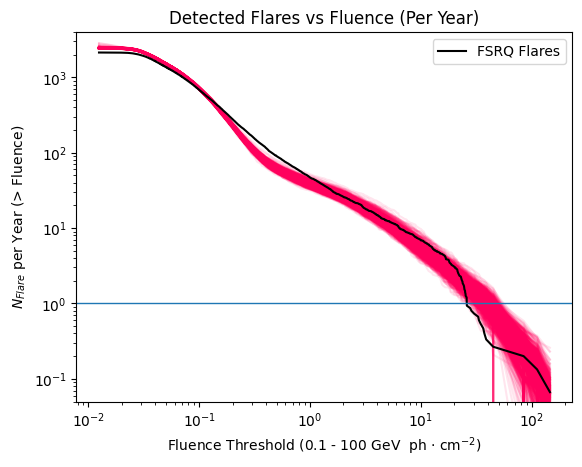

In [49]:
from scipy.interpolate import interp1d

plt.figure()
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories

for i in range(len(fluencethreshold_fsrq_all_white)):
    x_white=np.array(fluencethreshold_fsrq_all_white[i])
    y_white=np.array(fluencecount_fsrq_all_white[i])/15*573/139

    interp_function_white = interp1d(x_white, y_white, kind='linear', fill_value="extrapolate")
    y_white_interp = interp_function_white(fsrq_fluencethresholds_rep)
    y_white_interp[y_white_interp < 0] = 0    
    
    #plt.plot(fsrq_fluencethresholds_rep,y_white_interp, color=cl[0], alpha=0.1)
    
#for i in range(len(fluencethreshold_fsrq_all_red)):
    x_red=1.7*np.array(fluencethreshold_fsrq_all_red[i])*np.min(fsrq_fluencethresholds_rep[fsrq_fluencethresholds_rep>0])/np.min(fluencethreshold_fsrq_all_red[i])
    y_red=0.6*np.array(fluencecount_fsrq_all_red[i])/15*573/209
    
    interp_function_red = interp1d(x_red, y_red, kind='linear', fill_value="extrapolate")
    y_red_interp = interp_function_red(fsrq_fluencethresholds_rep)

    #plt.plot(fsrq_fluencethresholds_rep,y_red_interp, color=cl[0], alpha=0.1)
    plt.plot(fsrq_fluencethresholds_rep,y_red_interp+y_white_interp, color=cl[0], alpha=0.1)

plt.plot(fsrq_fluencethresholds_rep,fsrq_fluencecount_rep, color='k', label=label[0])
#plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)
plt.ylim(0.5e-1,4e3)

plt.legend()
plt.savefig('FSRQ_confidence_band.png',bbox_inches='tight')


/var/folders/sw/np3tt3hj7bl4fwmmj0hr4k1c0000gn/T/ipykernel_60802/4180186951.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BLL_confidence_band.png',bbox_inches='tight')


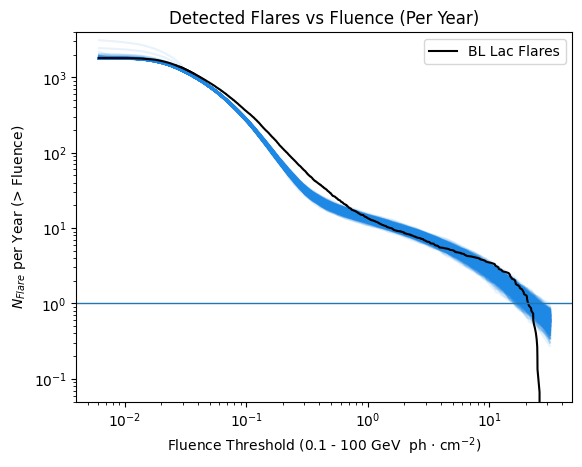

In [48]:
from scipy.interpolate import interp1d

plt.figure()
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories

for i in range(len(fluencethreshold_bll_all_white)):
    x_white=np.array(fluencethreshold_bll_all_white[i])
    y_white=np.array(fluencecount_bll_all_white[i])/15*478/272

    interp_function_white = interp1d(x_white, y_white, kind='linear', fill_value="extrapolate")
    y_white_interp = interp_function_white(bll_fluencethresholds_rep)
    y_white_interp[y_white_interp < 0] = 0  
    
    #plt.plot(bll_fluencethresholds_rep,y_white_interp, color=cl[1], alpha=0.1)

#for i in range(len(fluencethreshold_bll_all_red)):
    x_red=5.5*np.array(fluencethreshold_bll_all_red[i])*np.min(bll_fluencethresholds_rep[bll_fluencethresholds_rep>0])/np.min(fluencethreshold_bll_all_red[i])
    y_red=0.2*np.array(fluencecount_bll_all_red[i])/15*478/167
    
    interp_function_red = interp1d(x_red, y_red, kind='linear', fill_value="extrapolate")
    y_red_interp = interp_function_red(bll_fluencethresholds_rep)
    
    plt.plot(bll_fluencethresholds_rep,y_red_interp+y_white_interp, color=cl[1], alpha=0.1)

plt.plot(bll_fluencethresholds_rep,bll_fluencecount_rep, color='k', label=label[1])
#plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)
plt.ylim(0.5e-1,4e3)

plt.legend()
plt.savefig('BLL_confidence_band.png',bbox_inches='tight')


/var/folders/sw/np3tt3hj7bl4fwmmj0hr4k1c0000gn/T/ipykernel_60802/3142374168.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BCU_confidence_band.png',bbox_inches='tight')


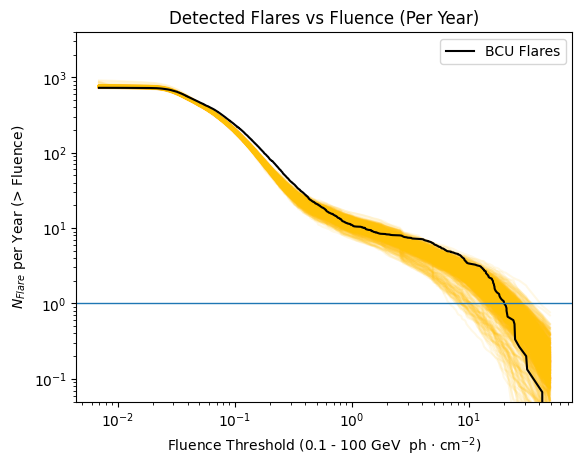

In [51]:
from scipy.interpolate import interp1d

plt.figure()
label = ['FSRQ Flares','BL Lac Flares','BCU Flares','All Flares'] # List of labels for categories
cl = ['#FF005D','#1E88E5','#FFC107','000000'] # List of colours for categories

for i in range(len(fluencethreshold_bcu_all_white)):
    x_white=np.array(fluencethreshold_bcu_all_white[i])
    y_white=np.array(fluencecount_bcu_all_white[i])/15*365/108

    interp_function_white = interp1d(x_white, y_white, kind='linear', fill_value="extrapolate")
    y_white_interp = interp_function_white(bcu_fluencethresholds_rep)
    y_white_interp[y_white_interp < 0] = 0  
    
    #plt.plot(bcu_fluencethresholds_rep,y_white_interp, color=cl[2], alpha=0.1)
    
#for i in range(len(fluencethreshold_bcu_all_red)):
    x_red=7.5*np.array(fluencethreshold_bcu_all_red[i])*np.min(bcu_fluencethresholds_rep[bcu_fluencethresholds_rep>0])/np.min(fluencethreshold_bcu_all_red[i])
    y_red=0.16*np.array(fluencecount_bcu_all_red[i])/15*365/144
    
    interp_function_red = interp1d(x_red, y_red, kind='linear', fill_value="extrapolate")
    y_red_interp = interp_function_red(bcu_fluencethresholds_rep)
    
    plt.plot(bcu_fluencethresholds_rep,y_red_interp+y_white_interp, color=cl[2], alpha=0.1)

plt.plot(bcu_fluencethresholds_rep,bcu_fluencecount_rep, color='k', label=label[2])
#plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.1 - 100 GeV  ph \u22c5 cm$^{-2}$)')
plt.title('Detected Flares vs Fluence (Per Year)')
plt.hlines(1,10**-3,10**3,linewidth=1)
plt.ylim(0.5e-1,4e3)

plt.legend()
plt.savefig('BCU_confidence_band.png',bbox_inches='tight')


In [23]:
print(len(glob.glob('./simulated_LC_FSRQ_'+cadence+'_contours/*')))
print(len(glob.glob('./simulated_LC_BLL_'+cadence+'_contours/*')))
print(len(glob.glob('./simulated_LC_BCU_'+cadence+'_contours/*')))

209
167
144


1000
1000
